# Predicting Category from Job Postings

In this workshop, we'll try a classification task involving text.

This task is to predict job categories from Google Job postings.

## Dataset
https://www.kaggle.com/niyamatalmass/google-job-skills/version/1

(Requires free Kaggle account)

## Setup

We'll be using spaCy, a popular library for natural language processing (https://spacy.io/) to do some basic text processing.

Run this from your conda environment:

```
conda install -y spacy
python -m spacy download en_core_web_sm
```

The first command installs spaCy. 

The second command downloads spaCy's English pre-trained model. Language models require separate downloads because they are big files and are different for each language you need.

scikit-learn also has some NLP support, but only English and not as powerful as spaCy.

## Data Exploration

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

In [90]:
df = pd.read_csv('D:/tmp/job-skills/job_skills.csv')
df.Category.unique()

array(['Program Management', 'Manufacturing & Supply Chain',
       'Technical Solutions', 'Developer Relations',
       'Hardware Engineering', 'Partnerships',
       'Product & Customer Support', 'Software Engineering',
       'Data Center & Network', 'Business Strategy', 'Technical Writing',
       'Technical Infrastructure', 'IT & Data Management',
       'Marketing & Communications', 'Network Engineering',
       'Sales & Account Management', 'Sales Operations', 'Finance',
       'Legal & Government Relations', 'Administrative',
       'User Experience & Design', 'People Operations',
       'Real Estate & Workplace Services'], dtype=object)

In [91]:
df.head()

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin..."
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...
3,Google,"Developer Advocate, Partner Engineering",Developer Relations,"Mountain View, CA, United States","Work one-on-one with the top Android, iOS, and...",BA/BS degree in Computer Science or equivalent...,"Experience as a software developer, architect,..."
4,Google,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Sunnyvale, CA, United States",Plan requirements with internal customers.\nPr...,BA/BS degree or equivalent practical experienc...,CTS Certification.\nExperience in the construc...


### Check for NaN

In [92]:
df.isnull().values.any()

True

In [93]:
# there are NA values, drop them and then check again
df.dropna(inplace=True)
df.isnull().values.any()

False

### Merge some smaller classes

In [94]:
df.groupby(['Category']).size()

Category
Administrative                       40
Business Strategy                    98
Data Center & Network                 2
Developer Relations                   5
Finance                             115
Hardware Engineering                 22
IT & Data Management                  5
Legal & Government Relations         46
Manufacturing & Supply Chain         16
Marketing & Communications          165
Network Engineering                   6
Partnerships                         59
People Operations                    86
Product & Customer Support           50
Program Management                   72
Real Estate & Workplace Services     25
Sales & Account Management          168
Sales Operations                     31
Software Engineering                 24
Technical Infrastructure             11
Technical Solutions                 100
Technical Writing                     5
User Experience & Design             84
dtype: int64

In [95]:
# Combine a few categories that are smaller, e.g.
#   Data Center & Network, Network Engineering, IT & Data Management => IT & Data Management

df.loc[df.Category == 'Data Center & Network', 'Category'] = 'IT & Data Management'
df.loc[df.Category == 'Network Engineering', 'Category'] = 'IT & Data Management'
df.groupby(['Category']).size()

Category
Administrative                       40
Business Strategy                    98
Developer Relations                   5
Finance                             115
Hardware Engineering                 22
IT & Data Management                 13
Legal & Government Relations         46
Manufacturing & Supply Chain         16
Marketing & Communications          165
Partnerships                         59
People Operations                    86
Product & Customer Support           50
Program Management                   72
Real Estate & Workplace Services     25
Sales & Account Management          168
Sales Operations                     31
Software Engineering                 24
Technical Infrastructure             11
Technical Solutions                 100
Technical Writing                     5
User Experience & Design             84
dtype: int64

## Data Transformation

### Label encoding

Label encode the 'Category' column into numbers to form our output (Y).

In [96]:
encoder = LabelEncoder()

category_enc = encoder.fit_transform(df.Category)

df['y'] = category_enc
df

,Company,Title,Category,Location,Responsibilities,Minimum Qualifications,Preferred Qualifications,y
0,Google,Google Cloud Program Manager,Program Management,Singapore,"Shape, shepherd, ship, and show technical prog...",BA/BS degree or equivalent practical experienc...,Experience in the business technology market a...,12
1,Google,"Supplier Development Engineer (SDE), Cable/Con...",Manufacturing & Supply Chain,"Shanghai, China",Drive cross-functional activities in the suppl...,BS degree in an Engineering discipline or equi...,"BSEE, BSME or BSIE degree.\nExperience of usin...",7
2,Google,"Data Analyst, Product and Tools Operations, Go...",Technical Solutions,"New York, NY, United States",Collect and analyze data to draw insight and i...,"Bachelor’s degree in Business, Economics, Stat...",Experience partnering or consulting cross-func...,18
3,Google,"Developer Advocate, Partner Engineering",Developer Relations,"Mountain View, CA, United States","Work one-on-one with the top Android, iOS, and...",BA/BS degree in Computer Science or equivalent...,"Experience as a software developer, architect,...",2
4,Google,"Program Manager, Audio Visual (AV) Deployments",Program Management,"Sunnyvale, CA, United States",Plan requirements with internal customers.\nPr...,BA/BS degree or equivalent practical experienc...,CTS Certification.\nExperience in the construc...,12
5,Google,"Associate Account Strategist (Czech/Slovak), G...",Technical Solutions,"Dublin, Ireland",Communicate with customers via phone and email...,Bachelor's degree or equivalent practical expe...,"Experience in sales, customer service, account...",18
6,Google,"Supplier Development Engineer, Camera, Consume...",Hardware Engineering,"Mountain View, CA, United States",Manage cross-functional activities in the supp...,BS degree in Engineering or equivalent practic...,Master's degree.\nExperience in the developmen...,4
7,Google,"Strategic Technology Partner Manager, Healthca...",Partnerships,"Sunnyvale, CA, United States",Lead the development and strategy with partner...,BA/BS degree or equivalent practical experienc...,"BA/BS degree in a technical, life sciences or ...",9
8,Google,"Manufacturing Business Manager, Google Hardware",Manufacturing & Supply Chain,"Xinyi District, Taiwan",Develop CM/ODM strategy and implement supplier...,"BA/BS degree in Engineering, Supply Chain or e...",MBA degree.\nExperience in procurement and sup...,7
9,Google,"Solutions Architect, Healthcare and Life Scien...",Technical Solutions,"New York, NY, United States",Help compile customer requirements as well as ...,"BA/BS degree in Computer Science, related Soft...","Master's degree in Computer Science, related E...",18


In [97]:
df.Responsibilities[0]

'Shape, shepherd, ship, and show technical programs designed to support the work of Cloud Customer Engineers and Solutions Architects.\nMeasure and report on key metrics tied to those programs to identify any need to change course, cancel, or scale the programs from a regional to global platform.\nCommunicate status and identify any obstacles and paths for resolution to stakeholders, including those in senior roles, in a transparent, regular, professional and timely manner.\nEstablish expectations and rationale on deliverables for stakeholders and program contributors.\nProvide program performance feedback to teams in Product, Engineering, Sales, and Marketing (among others) to enable efficient cross-team operations.'

### Text to Vectors (a little taste of NLP)

In order to train a model, we'll need convert the "Responsibilities" column from text into vectors.

Let's try:
1. Lemmatizing the words using English language rules (e.g. features -> feature)
2. Removing stop words such as "a", "the", "to" that don't contribute much semantic meaning.
3. Computing the TF-IDF (Term Frequency - Inverse Document Frequency) for each word (term) in the Responsibility column. This gives us a real number representation of each word.
4. Treat each word as a separate feature in X. (This is where lemmatizing and removing stop words will keep the number of features small.)

#### Notes:
The downside to this approach (while relatively simple), is that we end up with lots of features. However, this should be okay for a small corpus (couple thousand short sentences on a specific domain).

To handle larger corpora (hundreds of MBs to GBs), a more scalable approach is to train word vectors, which are slightly more involving (need hyperparameter guessing^H^H tuning). Word vectors will be overkill for this task, but an option once we've covered them in class.

In [98]:
# Example text we want to convert
df.Responsibilities[0]

'Shape, shepherd, ship, and show technical programs designed to support the work of Cloud Customer Engineers and Solutions Architects.\nMeasure and report on key metrics tied to those programs to identify any need to change course, cancel, or scale the programs from a regional to global platform.\nCommunicate status and identify any obstacles and paths for resolution to stakeholders, including those in senior roles, in a transparent, regular, professional and timely manner.\nEstablish expectations and rationale on deliverables for stakeholders and program contributors.\nProvide program performance feedback to teams in Product, Engineering, Sales, and Marketing (among others) to enable efficient cross-team operations.'

In [99]:
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

nlp = spacy.load('en_core_web_sm')
lemmatizer = Lemmatizer(LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES)

# transformation function to use in pd.DataFrame.apply()
def tokenize_text(text):
    """Tokenizes the text by lemmatizing and removing stop words
    Args:
        text - the input text
    Returns:
        a list of tokens
    """
    # process the text
    doc = nlp(text)
    
    # https://spacy.io/api/token
    lemmas = [lemmatizer(token.text, token.pos_) for token in doc
              if not token.is_stop and token.is_alpha]

    # create a string
    return ' '.join([item for sublist in lemmas for item in sublist])
            
# Test
tokenize_text(df.Responsibilities[0])

'shape shepherd ship technical program design support work cloud customer engineers solutions architects measure report key metric tie program identify need change course cancel scale program regional global platform communicate statu identify obstacle path resolution stakeholder include senior role transparent regular professional timely manner establish expectation rationale deliverable stakeholder program contributor provide program performance feedback team product engineering sale marketing enable efficient cros team operation'

In [100]:
# Tokenize the column
df_tokenized = df.Responsibilities.apply(tokenize_text)
df_tokenized.head()

0    shape shepherd ship technical program design s...
1    drive cros functional activity supply chain ov...
2    collect analyze datum draw insight identify st...
3    work android ios web engineer build exciting n...
4    plan requirement internal customer provide por...
Name: Responsibilities, dtype: object

### TF-IDF

See text.ipynb under 'Frequency Analysis' for formulas.

- We'll perform frequency analysis on each term (e.g. 'shape' across all documents).
- Each Job Responsibility is treated as a "document".
- Frequency analysis will compute a number indicating how important that word is in the corpus.
- Rare words that have high importance are accorded higher weight (e.g. datum or shepherd).

http://scikit-learn.org/stable/modules/feature_extraction.html#tfidf-term-weighting

In [101]:
# Apply the vectorizer on all tokenized Responsibility rows

vectorizer = TfidfVectorizer(lowercase=False, decode_error='ignore')

X = vectorizer.fit_transform(df_tokenized)

# convert sparse matrix to dense matrix
X_dense = X.todense()

print(X_dense.shape)

# print the features
print(vectorizer.get_feature_names())

(1235, 2972)


['ability', 'able', 'abreast', 'abroad', 'absence', 'abstraction', 'abuse', 'academia', 'accelerate', 'accelerated', 'acceleration', 'accelerator', 'accept', 'acceptance', 'acces', 'accessibility', 'accessory', 'accommodate', 'accommodation', 'accomplish', 'accomplishment', 'accord', 'accordance', 'accordingly', 'account', 'accountability', 'accountable', 'accounting', 'accounts', 'accrual', 'accuracy', 'accurate', 'accurately', 'achieve', 'achievement', 'achiv', 'achive', 'acquire', 'acquisition', 'act', 'action', 'actionable', 'activate', 'activation', 'active', 'actively', 'activity', 'actual', 'actualize', 'acuman', 'ad', 'adapt', 'add', 'addition', 'additional', 'additionally', 'additive', 'addres', 'address', 'addressable', 'adequate', 'adhere', 'adherence', 'adheres', 'adhoc', 'adjust', 'adjustment', 'administer', 'administration', 'administrative', 'admission', 'admob', 'adopt', 'adoption', 'ads', 'adsense', 'advance', 'advanced', 'advancement', 'advantage', 'adversely', 'adver

## Visualize

t-SNE (t-Distributed Stochastic Neighbour Embedding) is more suited for sparse features than PCA.

Text features are "sparse" because not all the same words always appear.

In [102]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X_dense)

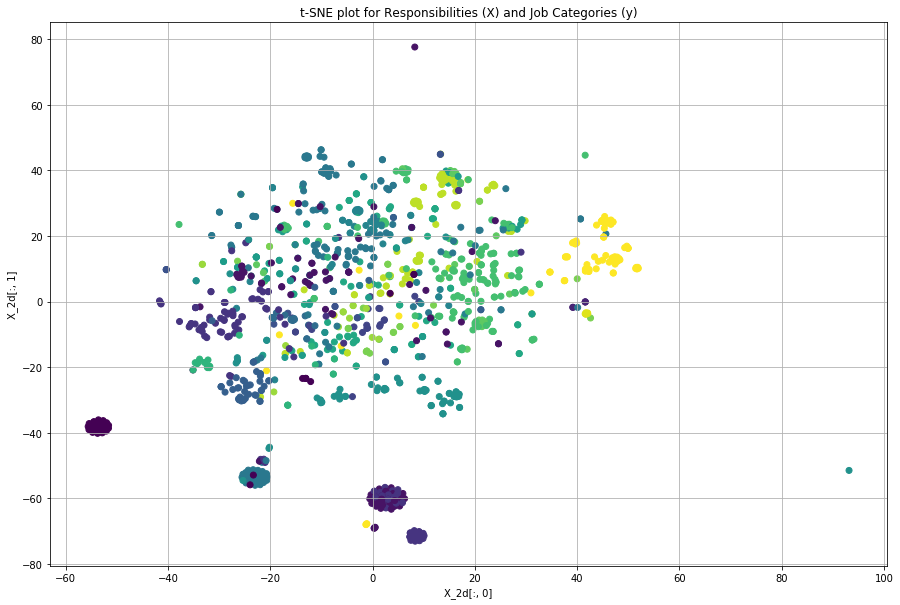

In [103]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X_2d[:, 0], X_2d[:, 1], c=df.y)

ax.set(title='t-SNE plot for Responsibilities (X) and Job Categories (y)',
       xlabel='X_2d[:, 0]', ylabel='X_2d[:, 1]')
ax.grid()
plt.show()

In [104]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dense, df.y, random_state=42)

In [105]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier # just for kicks
from sklearn.svm import SVC

from sklearn.metrics import classification_report

classifiers = [
    DummyClassifier(random_state=42),
    LogisticRegression(random_state=42),
    SGDClassifier(random_state=42, tol=1e-8, max_iter=1000),
    GaussianNB(),
    SVC(kernel='poly', degree=5, random_state=42),
    KNeighborsClassifier(),
    MLPClassifier(random_state=42, tol=1e-8, max_iter=1000)
]

for clf in classifiers:
    print(type(clf))
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(classification_report(y_test, pred))

<class 'sklearn.dummy.DummyClassifier'>
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         6
          1       0.10      0.10      0.10        31
          2       0.00      0.00      0.00         1
          3       0.18      0.13      0.15        30
          4       0.00      0.00      0.00         2
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         7
          7       0.00      0.00      0.00         6
          8       0.12      0.12      0.12        42
          9       0.12      0.15      0.14        13
         10       0.12      0.16      0.14        19
         11       0.14      0.05      0.07        20
         12       0.07      0.06      0.06        17
         13       0.00      0.00      0.00         6
         14       0.23      0.21      0.22        48
         15       0.11      0.14      0.12         7
         16       0.00      0.00      0.00         4
     

C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       1.00      0.50      0.67         6
          1       0.44      0.23      0.30        31
          2       0.00      0.00      0.00         1
          3       0.60      0.83      0.69        30
          4       0.00      0.00      0.00         2
          5       0.00      0.00      0.00         4
          6       1.00      0.86      0.92         7
          7       1.00      0.67      0.80         6
          8       0.55      0.90      0.68        42
          9       0.50      0.46      0.48        13
         10       0.84      0.84      0.84        19
         11       1.00      0.05      0.10        20
         12       0.69      0.53      0.60        17
         13       0.75      0.50      0.60         6
         14       0.63      0.83      0.72        48
         15       0.00      0.00      0.00         7
         16       1.00      0.25      0.40         4
         17       0.00      0.00      0.00   

## Learning Curve

Example of learning curve.

C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\neural_network\multilayer_perce

train_size mean_train_score mean_val_score
60 0.9888888888888889 0.4340408742492176
197 0.9898477157360407 0.6052293444192441
334 0.9870259481037924 0.666479723143481
471 0.97310686482661 0.708557792019949
609 0.9556650246305418 0.7243828907309607


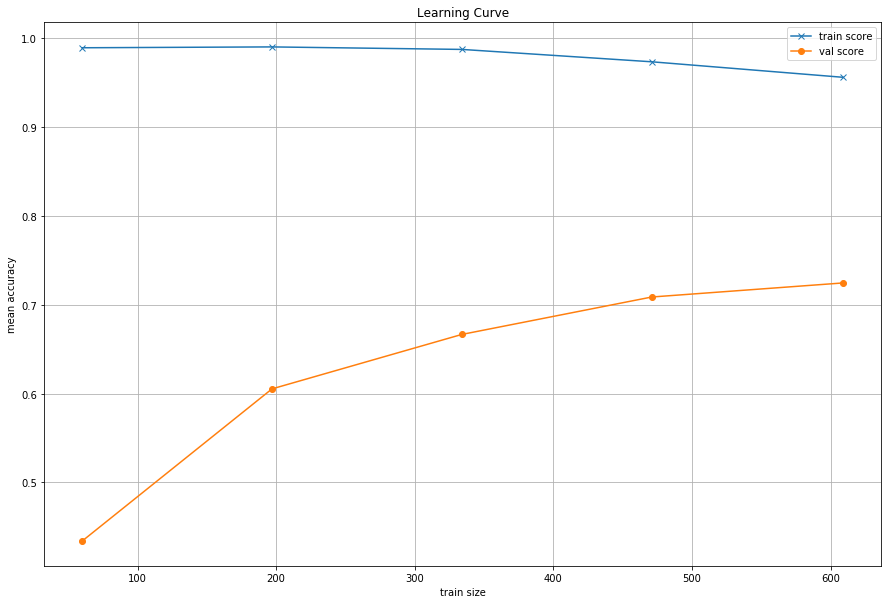

In [106]:
from sklearn.model_selection import learning_curve

clf = MLPClassifier(random_state=42, tol=1e-8, max_iter=1000)
train_sizes, train_score, val_score = learning_curve(clf, X_train, y_train)

train_mean = np.mean(train_score, axis=1)
val_mean = np.mean(val_score, axis=1)

print('train_size', 'mean_train_score', 'mean_val_score')
for train_size, t, m in zip(train_sizes, train_mean, val_mean):
    print(train_size, t, m)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(train_sizes, train_mean, label='train score', marker='x')
ax.plot(train_sizes, val_mean, label='val score', marker='o')

ax.set(xlabel='train size', ylabel='mean accuracy', title='Learning Curve')
ax.grid()
ax.legend()
plt.show()    

## Predictions

Let's perform some predictions with real job postings.

1. https://careers.google.com/jobs/
2. Pick a posting, copy the Job Responsibilities
3. Transform the input by tokenizing and then using the TfIdfVectorizer
4. Get the prediction

In [107]:
# https://careers.google.com/jobs/#!t=jo&jid=/google/migrations-architect-google-cloud-singapore-3974200108&

test = """Work closely with strategic clients, both engineering and non-technical, to lead migration projects and customer implementations on Google Cloud.
Coordinate with a diverse team of stakeholders and supporting Googlers, including Sales, Solutions Engineers and the Professional Services organization.
Build core migration tooling across all Google Cloud Platform products and relevant third-party software.
Establish and drive planning and execution steps towards production deployments.
Write/develop deployment templates, orchestration scripting, database replication configurations, CI/CD pipeline assemblies, etc."""

token_string = tokenize_text(test)
test_tfidf = vectorizer.transform([token_string]).todense()

for clf in classifiers:
    print(clf) # prints the classifier information
    pred = clf.predict(test_tfidf)
    print(encoder.inverse_transform(pred))
    print()

DummyClassifier(constant=None, random_state=42, strategy='stratified')


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Business Strategy']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Technical Solutions']

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=1e-08, verbose=0, warm_start=False)


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Technical Solutions']

GaussianNB(priors=None)


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Technical Solutions']

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Marketing & Communications']

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Program Management']

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=1e-08, validation_fraction=0.1, verbose=False,
       warm_start=False)


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Technical Solutions']



In [109]:
# https://careers.google.com/jobs#!t=jo&jid=/google/developer-advocate-payments-singapore-4098320134&

test = """Define and execute on the developer outreach strategy in coordination with Product Management, Engineering and cross-functional leadership.
Plan and run scaled developer outreach programs, potentially including large-scale public events, developer blogs/forums, and scaled acquisition programs (e.g. emails, assisted sign-up, etc).
Collaborate with local cross-functional teams (e.g. Google Technical Services, Marketing, etc) to update and maintain product positioning and narrative, case studies, developer sites, associated documents and code samples.
Act as a strategic partner to the Product teams and establish deeper developer insights and an understanding of associated needs through gathering market intelligence and research."""

token_string = tokenize_text(test)
test_tfidf = vectorizer.transform([token_string]).todense()

for clf in classifiers:
    print(clf) # prints the classifier information
    pred = clf.predict(test_tfidf)
    print(encoder.inverse_transform(pred))
    print()

DummyClassifier(constant=None, random_state=42, strategy='stratified')


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Business Strategy']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Marketing & Communications']

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=1000, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=1e-08, verbose=0, warm_start=False)


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Marketing & Communications']

GaussianNB(priors=None)


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Marketing & Communications']

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=5, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False)


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Marketing & Communications']

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Technical Writing']

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=1000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=1e-08, validation_fraction=0.1, verbose=False,
       warm_start=False)


C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


['Marketing & Communications']



In [110]:
# How to see stop words
from spacy.lang.en.stop_words import STOP_WORDS

STOP_WORDS

{'a',
 'about',
 'above',
 'across',
 'after',
 'afterwards',
 'again',
 'against',
 'all',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'am',
 'among',
 'amongst',
 'amount',
 'an',
 'and',
 'another',
 'any',
 'anyhow',
 'anyone',
 'anything',
 'anyway',
 'anywhere',
 'are',
 'around',
 'as',
 'at',
 'back',
 'be',
 'became',
 'because',
 'become',
 'becomes',
 'becoming',
 'been',
 'before',
 'beforehand',
 'behind',
 'being',
 'below',
 'beside',
 'besides',
 'between',
 'beyond',
 'both',
 'bottom',
 'but',
 'by',
 'ca',
 'call',
 'can',
 'cannot',
 'could',
 'did',
 'do',
 'does',
 'doing',
 'done',
 'down',
 'due',
 'during',
 'each',
 'eight',
 'either',
 'eleven',
 'else',
 'elsewhere',
 'empty',
 'enough',
 'even',
 'ever',
 'every',
 'everyone',
 'everything',
 'everywhere',
 'except',
 'few',
 'fifteen',
 'fifty',
 'first',
 'five',
 'for',
 'former',
 'formerly',
 'forty',
 'four',
 'from',
 'front',
 'full',
 'further',
 'get',
 'give',
 'g

## Text Feature Extraction - TF-IDF and N-grams

Ngrams can improve the model accuracy by extracting features by considering multiple words together, rather than each word individually.

However, Ngrams will slow down featurization and training because it increases the number of features.

In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer
text1 = "I like food."
text2 = "I like to read."
text = [text1, text2]

vectorizer = TfidfVectorizer()
tfidf_sparse = vectorizer.fit_transform(text)
tfidf_sparse

<2x4 sparse matrix of type '<class 'numpy.float64'>'
	with 5 stored elements in Compressed Sparse Row format>

In [112]:
tfidf = tfidf_sparse.todense()
tfidf

matrix([[0.81480247, 0.57973867, 0.        , 0.        ],
        [0.        , 0.44943642, 0.6316672 , 0.6316672 ]])

In [113]:
# :(
# https://stackoverflow.com/questions/33260505/countvectorizer-ignoring-i

vectorizer.get_feature_names()

['food', 'like', 'read', 'to']

In [114]:
vectorizer.vocabulary_

{'like': 1, 'food': 0, 'to': 3, 'read': 2}

In [115]:
vectorizer.idf_

array([1.40546511, 1.        , 1.40546511, 1.40546511])

In [116]:
vectorizer.stop_words_

set()

In [117]:
# 2 grams
vectorizer_ngram = TfidfVectorizer(ngram_range=(2, 2))
tfidf_ngram = vectorizer_ngram.fit_transform(text).todense()
tfidf_ngram

matrix([[1.        , 0.        , 0.        ],
        [0.        , 0.70710678, 0.70710678]])

In [118]:
vectorizer_ngram.get_feature_names()

['like food', 'like to', 'to read']

In [119]:
vectorizer.vocabulary_

{'like': 1, 'food': 0, 'to': 3, 'read': 2}

In [120]:
# 1 and 2-grams
vectorizer_ngrams = TfidfVectorizer(ngram_range=(1, 2))
tfidf_ngrams = vectorizer_ngrams.fit_transform(text).todense()
tfidf_ngrams

matrix([[0.6316672 , 0.44943642, 0.6316672 , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.33517574, 0.        , 0.47107781, 0.47107781,
         0.47107781, 0.47107781]])

In [121]:
vectorizer_ngrams.get_feature_names()

['food', 'like', 'like food', 'like to', 'read', 'to', 'to read']

# Exercise - Ngrams with Google Jobs Dataset (45 minutes)

1. Re-generate the text features using 2-grams
2. Re-plot t-SNE with the new features and compare with the previous plot.
3. Train your classification models with the new features and compare the `classification_report` metric.

(Note that MLPClassifier and SVM may take longer to train)

Optional exercise:
4. Try a mixture of 1 and 2 grams, or try 3-grams.

In [123]:
# Re-generate the text features using 2-grams

vectorizer_2gram = TfidfVectorizer(lowercase=False, decode_error='ignore', ngram_range=(2, 2))

X = vectorizer_2gram.fit_transform(df_tokenized)

# convert sparse matrix to dense matrix
X_dense = X.todense()

print(X_dense.shape)

# print the features
print(vectorizer_2gram.get_feature_names())


(1235, 26428)


['ability area', 'ability automate', 'ability balance', 'ability grow', 'ability manage', 'ability understand', 'able articulate', 'able build', 'able come', 'able job', 'able prioritize', 'able provide', 'able qualify', 'able run', 'able support', 'abreast relevant', 'abroad include', 'absence include', 'abstraction level', 'abstraction pertinent', 'abuse action', 'abuse analyst', 'abuse busines', 'abuse experiment', 'abuse fight', 'abuse learn', 'abuse loophole', 'abuse operational', 'abuse operations', 'abuse problem', 'abuse research', 'abuse spam', 'abuse system', 'abuse team', 'abuse work', 'abuse youtube', 'academia support', 'accelerate agreement', 'accelerate scale', 'accelerate simulation', 'accelerate successful', 'accelerate waze', 'accelerated mobile', 'acceleration design', 'accelerator coordinate', 'accelerator memory', 'accelerator peripheral', 'accelerator sector', 'accept accounting', 'acceptance decline', 'acceptance mechanism', 'acces control', 'acces critical', 'ac

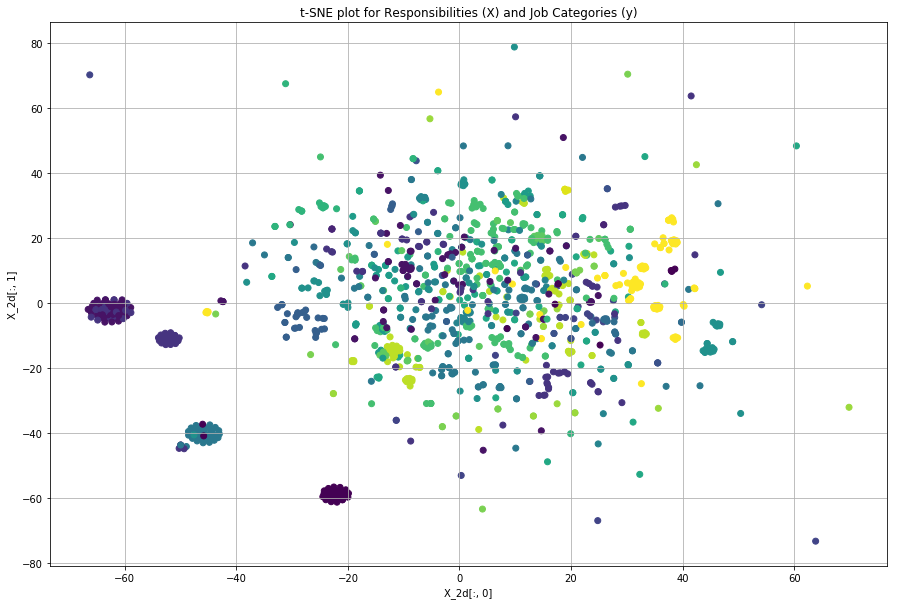

In [124]:
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X_dense)

fig, ax = plt.subplots(figsize=(15, 10))

ax.scatter(X_2d[:, 0], X_2d[:, 1], c=df.y)

ax.set(title='t-SNE plot for Responsibilities (X) and Job Categories (y)',
       xlabel='X_2d[:, 0]', ylabel='X_2d[:, 1]')
ax.grid()
plt.show()

In [126]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dense, df.y, random_state=42)

classifiers = [
    DummyClassifier(random_state=42),
    LogisticRegression(random_state=42),
    SGDClassifier(random_state=42, tol=1e-8, max_iter=1000),
    GaussianNB(),
    SVC(kernel='poly', degree=5, random_state=42),
    KNeighborsClassifier(),
    MLPClassifier(random_state=42, tol=1e-8, max_iter=1000)
]

for clf in classifiers:
    print(type(clf))
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    print(classification_report(y_test, pred))

<class 'sklearn.dummy.DummyClassifier'>
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         6
          1       0.10      0.10      0.10        31
          2       0.00      0.00      0.00         1
          3       0.18      0.13      0.15        30
          4       0.00      0.00      0.00         2
          5       0.00      0.00      0.00         4
          6       0.00      0.00      0.00         7
          7       0.00      0.00      0.00         6
          8       0.12      0.12      0.12        42
          9       0.12      0.15      0.14        13
         10       0.12      0.16      0.14        19
         11       0.14      0.05      0.07        20
         12       0.07      0.06      0.06        17
         13       0.00      0.00      0.00         6
         14       0.23      0.21      0.22        48
         15       0.11      0.14      0.12         7
         16       0.00      0.00      0.00         4
     

C:\Users\issohl\AppData\Local\Continuum\miniconda3\envs\mldds02\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       1.00      0.50      0.67         6
          1       0.80      0.26      0.39        31
          2       0.00      0.00      0.00         1
          3       0.46      0.43      0.45        30
          4       0.00      0.00      0.00         2
          5       0.00      0.00      0.00         4
          6       1.00      0.14      0.25         7
          7       1.00      0.33      0.50         6
          8       0.40      0.95      0.56        42
          9       0.83      0.38      0.53        13
         10       0.92      0.63      0.75        19
         11       1.00      0.05      0.10        20
         12       1.00      0.29      0.45        17
         13       1.00      0.50      0.67         6
         14       0.48      0.96      0.64        48
         15       0.00      0.00      0.00         7
         16       1.00      0.25      0.40         4
         17       0.00      0.00      0.00   

In [ ]:
from sklearn.model_selection import GridSearchCV

cv = GridSearchCV(SVC(degree=5, random_state=42))
                  {'degree':, random_state=42)

cv.fit(X_train, y_train)
pred = cv.predict(X_test)
print(classification_report(y_test, pred))